In [17]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.insert(1, "./utils/")
import HH, Stimuli
from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms

## Simulations for reconstruction

In [18]:
sim_length = 100_000

In [19]:
# generate stimuli
stim_types = ['base','lw','lt','lwlt','burst']

e_times = Stimuli.poisson_process_duration(5, sim_length)
i_times = Stimuli.poisson_process_duration(15, sim_length)

stim_scaffold = {
    'base': {
        'ex': Stimuli.PoissonStim(
            'ex_base', 'ex_base',
            interval=5,
            rev_potential=0,
            weight=0.0002,
            tau=2,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_base', 'in_base',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=6,
            seed='na'
        )
    },
    'lw': {
        'ex': Stimuli.PoissonStim(
            'ex_lw', 'ex_lw',
            interval=5,
            rev_potential=0,
            weight=0.00015,
            tau=2,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lw', 'in_lw',
            interval=15,
            rev_potential=-80,
            weight=0.0002,
            tau=6,
            seed='na'
        )
    },
    'lt': {
        'ex': Stimuli.PoissonStim(
            'ex_lt', 'ex_lt',
            interval=5,
            rev_potential=0,
            weight=0.0002,
            tau=10,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lt', 'in_lt',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=40,
            seed='na'
        )
    },
    'lwlt': {
        'ex': Stimuli.PoissonStim(
            'ex_lwlt', 'ex_lwlt',
            interval=5,
            rev_potential=0,
            weight=0.00015,
            tau=10,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lwlt', 'in_lwlt',
            interval=15,
            rev_potential=-80,
            weight=0.0002,
            tau=40,
            seed='na'
        )
    },
    'burst': {
        'ex': Stimuli.PoissonStim(
            'ex_burst', 'ex_burst',
            interval=5,
            rev_potential=0,
            weight=0.0001,
            tau=40,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_burst', 'in_burst',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=20,
            seed='na'
        )
    }
}

for stim_type in stim_types:
    stim_scaffold[stim_type]['ex'].stim_times = e_times
    stim_scaffold[stim_type]['in'].stim_times = i_times

In [20]:
simulations = {
    'base':HH.HH(),
    'lw':HH.HH(),
    'lt':HH.HH(),
    'lwlt':HH.HH(),
    'burst':HH.HH()
}

for stim_type in stim_types:
    simulations[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['ex'])
    simulations[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['in'])

In [21]:
h.finitialize(-65)
h.continuerun(sim_length * ms)

0.0

In [22]:
# the sims get written over when new NEURON sims are run, so commit the data
simulation_data = {
    stim_type:{
        'spike_times':list(simulations[stim_type].spike_times),
        'df':np.array(
            (
                simulations[stim_type]._t,
                simulations[stim_type]._v,
                simulations[stim_type]._m,
                simulations[stim_type]._h,
                simulations[stim_type]._n
            )
        )
    } for stim_type in stim_types
}

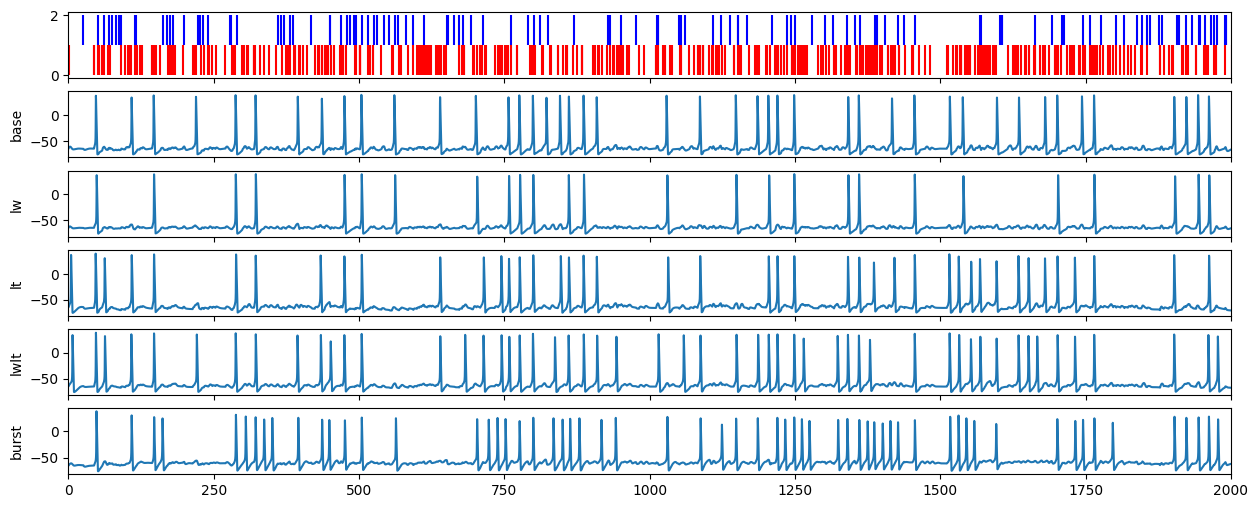

In [23]:
fig, axes = plt.subplots(6,1, figsize=(15,6), sharex=True)

axes[0].vlines(e_times, 0, 1, 'red')
axes[0].vlines(i_times, 1, 2, 'blue')

for i, stim_type in enumerate(stim_types):
    axes[i+1].plot(simulations[stim_type]._t, simulations[stim_type]._v)
    axes[i+1].set_ylabel(stim_type)
    
axes[i].set_xlim(0,2000)
plt.show()

In [24]:
for stim_type in stim_types:
    print(f'number of spikes for {stim_type}:\t{len(simulations[stim_type].spike_times)}')

number of spikes for base:	2221
number of spikes for lw:	1450
number of spikes for lt:	1833
number of spikes for lwlt:	2377
number of spikes for burst:	3041


## Median spiking history

In [25]:
def standarize_column(column):
    # set column to fit in (0,1)
    column = column-np.min(column)
    column = column/np.max(column)
    return column

def dist(p1, p2):
    # get distance between 2 standardized histories
    return np.sqrt(pow(p1['v']-p2['v'], 2) + pow(p1['m']-p2['m'], 2) + pow(p1['n']-p2['n'], 2) + pow(p1['h']-p2['h'], 2))

def isolate_spiking_histories(sim):
    spiking_histories = []
    for spike in sim.spike_times:
        row = round(40 * spike)
        spiking_histories.append(
            pd.DataFrame(
                {
                    'v':[sim._v[row]], 
                    'm':[sim._m[row]], 
                    'n':[sim._n[row]], 
                    'h':[sim._h[row]]
                }
            )
        )                                  
    return pd.concat(spiking_histories)

# find median spiking histories
def get_median_history_from_vecs(df):
    _v = standarize_column(np.array(df['v']))
    _m = standarize_column(np.array(df['m']))
    _n = standarize_column(np.array(df['n']))
    _h = standarize_column(np.array(df['h']))

    # calculate the median of each state variable
    median_values = {
        'v': np.median(_v),
        'm': np.median(_m),
        'n': np.median(_n),
        'h': np.median(_h)
    }
    
    dists = []
    for i in range(len(_v)):
        dists.append(dist({'v':_v[i],'m':_m[i],'n':_n[i],'h':_h[i]}, median_values))

    return {
            'v': df['v'].iloc[np.argmin(dists)],
            'm': df['m'].iloc[np.argmin(dists)],
            'n': df['n'].iloc[np.argmin(dists)],
            'h': df['h'].iloc[np.argmin(dists)]
    }

In [26]:
spiking_histories = {
    'base':isolate_spiking_histories(simulations['base']),
    'lw':isolate_spiking_histories(simulations['lw']),
    'lt':isolate_spiking_histories(simulations['lt']),
    'lwlt':isolate_spiking_histories(simulations['lwlt']),
    'burst':isolate_spiking_histories(simulations['burst'])
}

median_spiking_histories = {
    'base':get_median_history_from_vecs(spiking_histories['base']),
    'lw':get_median_history_from_vecs(spiking_histories['lw']),
    'lt':get_median_history_from_vecs(spiking_histories['lt']),
    'lwlt':get_median_history_from_vecs(spiking_histories['lwlt']),
    'burst':get_median_history_from_vecs(spiking_histories['burst'])
}

## reconstruct after spike

In [27]:
reconstruct_duration = 100
num_reconstructs = 1000

original_dfs = {} # store the real dfs here, to compare against the reconstructed dfs
reconstruction_cells = {}
fihs = [] # store fInitializeHandlers here

for stim_type in stim_types:
    spike_times = simulation_data[stim_type]['spike_times']
    o_history = median_spiking_histories[stim_type]

    viable_spikes = [spike for spike in spike_times if (spike < sim_length - reconstruct_duration) and (spike > 100)]
    spike_inds = np.random.choice(np.arange(0, len(viable_spikes)), num_reconstructs, replace=False)

    original_dfs[stim_type] = []
    reconstruction_cells[stim_type] = [HH.HH() for i in range(num_reconstructs)]
    

    for i in range(num_reconstructs):
        cell = reconstruction_cells[stim_type][i]
        starting_spike = spike_times[i]
        
        # find original df
        start_ind = int(starting_spike * 40)
        end_ind = start_ind + (reconstruct_duration * 40) + 1
        original_dfs[stim_type].append(simulation_data[stim_type]['df'][:,start_ind:end_ind])

        # inject stimuli
        _e_times = [
            t-starting_spike for t in e_times if (t > starting_spike) and (t < starting_spike + reconstruct_duration)
        ]
        _i_times = [
            t-starting_spike for t in i_times if (t > starting_spike) and (t < starting_spike + reconstruct_duration)
        ]

        _e_stims = Stimuli.PoissonStim(
            rev_potential = stim_scaffold[stim_type]['ex'].rev_potential,
            weight = stim_scaffold[stim_type]['ex'].weight,
            tau = stim_scaffold[stim_type]['ex'].tau,
            stim_times = _e_times,
        )

        _i_stims = Stimuli.PoissonStim(
            rev_potential = stim_scaffold[stim_type]['in'].rev_potential,
            weight = stim_scaffold[stim_type]['in'].weight,
            tau = stim_scaffold[stim_type]['in'].tau,
            stim_times = _i_times,
        )

        cell.add_custom_stimulus(_e_stims)
        cell.add_custom_stimulus(_i_stims)

        # initialize
        cell.sim_init(
            v0 = o_history['v'],
            m0 = o_history['m'],
            h0 = o_history['h'],
            n0 = o_history['n']
        )

        fihs.append(h.FInitializeHandler(cell.do_sim_init))

In [28]:
h.finitialize(-65)
h.continuerun(reconstruct_duration * ms)

reconstructed_dfs = {
    stim_type:[
        np.array((cell._t, cell._v, cell._m, cell._h,cell._n)) for cell in reconstruction_cells[stim_type]
    ] for stim_type in stim_types
}

In [33]:
rbase = np.array(original_dfs['base'])
rbase.shape

(1000, 5, 4001)

[]

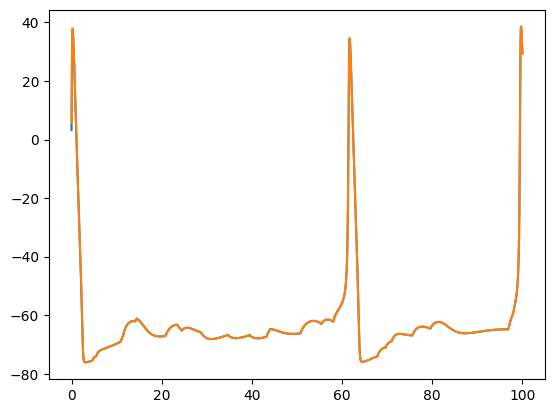

In [29]:
ind = 0
plt.plot(reconstructed_dfs['base'][ind][0,:], reconstructed_dfs['base'][ind][1,:])
plt.plot(reconstructed_dfs['base'][ind][0,:], original_dfs['base'][ind][1,:])
plt.plot()

## calculate the error as a function of time

In [ ]:
stim_type = 'base'
errors = []
for i in range(num_reconstructs):
    reconstructed_df = reconstructed_dfs[stim_type][i][1:,:]
    original_df = original_dfs[stim_type][i][1:,:]
    errors.append(original_df - reconstructed_df)

In [ ]:
squared_errors = [error**2 for error in errors]
absolute_errors = [np.abs(error) for error in errors]

mean_squared_error = np.sum(squared_errors, axis=0) / num_reconstructs
mean_absolute_error = np.sum(absolute_errors, axis=0) / num_reconstructs

In [ ]:
for error in errors:
    plt.plot(error[0,:])

In [ ]:
for error in squared_errors:
    plt.plot(error[0,:])

In [ ]:
for error in absolute_errors:
    plt.plot(error[0,:])

In [ ]:
plt.plot(mean_squared_error[0,:])

In [ ]:
plt.plot(mean_absolute_error[0,:])